# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

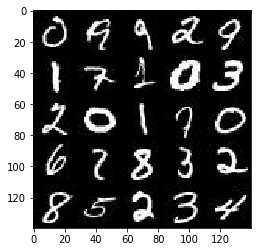

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

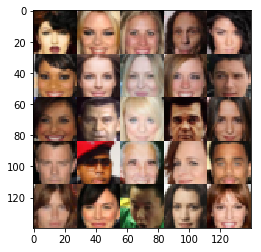

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [20]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, None, name='learning_rate')
    
    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [21]:
def discriminator(images, reuse=False, alpha=0.1, stddev=0.02):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Layer 1 in: 28x28x(1|3)
        layer_1 = tf.layers.conv2d(images, 32, 5, 2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_1 = tf.maximum(alpha * layer_1, layer_1)
        # Layer 1 out: 14x14x32
        
        # Layer 2: 14x14x32
        layer_2 = tf.layers.conv2d(layer_1, 64, 5, 2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_2 = tf.layers.batch_normalization(layer_2, training=True)
        layer_2 = tf.maximum(alpha * layer_2, layer_2)
        # Layer 2 out: 7x7x64
        
        layer_3 = tf.layers.conv2d(layer_2, 128, 5, 2, padding='same',  kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_3 = tf.layers.batch_normalization(layer_3, training=True)
        layer_3 = tf.maximum(alpha * layer_3, layer_3)
        # Layer 3 out: 4x4x128
        
        layer_4 = tf.layers.conv2d(layer_3, 256, 5, 2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_4 = tf.layers.batch_normalization(layer_4, training=True)
        layer_4 = tf.maximum(alpha * layer_4, layer_4)
        # Layer 4 out: 2x2x256
        
        flattened = tf.reshape(layer_4, (-1, 2*2*256))
        logits = tf.layers.dense(flattened, 1, kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        output = tf.sigmoid(logits)
        
        return output, logits
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [22]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1, stddev=0.02):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        # Layer 1 in: 7x7x256
        layer_1 = tf.layers.dense(z, 4 * 4 * 512)
        layer_1 = tf.reshape(layer_1, (-1, 4, 4, 512))
        layer_1 = tf.layers.batch_normalization(layer_1, training=is_train)
        layer_1 = tf.maximum(alpha * layer_1, layer_1)
        # Layer 1 out: 4x4x512
        
        layer_2 = tf.layers.conv2d_transpose(layer_1, 128, 4, 1, padding='valid', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_2 = tf.layers.batch_normalization(layer_2, training=is_train)
        layer_2 = tf.maximum(alpha * layer_2, layer_2)
        # Layer 2 out: 8x8x128
        
        layer_3 = tf.layers.conv2d_transpose(layer_2, 64, 5, 2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_3 = tf.layers.batch_normalization(layer_3, training=is_train)
        layer_3 = tf.maximum(alpha * layer_3, layer_3)
        # Layer 3 out: 16x16x64
        
        layer_4 = tf.layers.conv2d_transpose(layer_3, 32, 5, 2, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_4 = tf.layers.batch_normalization(layer_4, training=is_train)
        layer_4 = tf.maximum(alpha * layer_4, layer_4)
        # Layer 4 out: 32x32x32
        
        logits = tf.layers.conv2d_transpose(layer_4, out_channel_dim, 3, 1, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        output = tf.tanh(logits)
        
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [23]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    gen_model = generator(input_z, out_channel_dim)
    dis_model_real, dis_logits_real = discriminator(input_real)
    dis_model_fake, dis_logits_fake = discriminator(gen_model, reuse=True)
    
    dis_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_real, labels=tf.ones_like(dis_logits_real) * 0.9))
    dis_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_fake, labels=tf.zeros_like(dis_logits_fake)))
    dis_loss = dis_loss_real + dis_loss_fake
    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_fake, labels=tf.ones_like(dis_logits_fake)))
    
    return dis_loss, gen_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [24]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    train_vars = tf.trainable_variables()
    dis_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    gen_vars = [var for var in train_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    gen_updates = [op for op in update_ops if op.name.startswith('generator')]
    
    with tf.control_dependencies(gen_updates):
        dis_train_ops = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=dis_vars)
        gen_train_ops = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
    
        return dis_train_ops, gen_train_ops


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [26]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [29]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, in_learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    dis_loss, gen_loss = model_loss(input_real, input_z, image_channels)
    dis_ops, gen_ops = model_opt(dis_loss, gen_loss, learning_rate, beta1)
    
    steps = 0
    
    print_every = 10
    show_every = 100
    
    saver = tf.train.Saver()
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_images *= 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(dis_ops, feed_dict={ input_real: batch_images, input_z: batch_z, in_learning_rate: learning_rate })
                _ = sess.run(gen_ops, feed_dict={ input_z: batch_z, in_learning_rate: learning_rate })
                
                if steps % print_every == 0:
                    dis_loss_train = dis_loss.eval({
                        input_z: batch_z,
                        input_real: batch_images
                    })
                    gen_loss_train = gen_loss.eval({
                        input_z: batch_z
                    })
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                         "Discriminator Loss: {:.4f}...".format(dis_loss_train),
                         "Generator Loss: {:.4f}".format(gen_loss_train))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.6357... Generator Loss: 0.3171
Epoch 1/2... Discriminator Loss: 3.6735... Generator Loss: 0.0365
Epoch 1/2... Discriminator Loss: 1.0493... Generator Loss: 0.9130
Epoch 1/2... Discriminator Loss: 0.6135... Generator Loss: 2.3035
Epoch 1/2... Discriminator Loss: 0.3849... Generator Loss: 3.2563
Epoch 1/2... Discriminator Loss: 0.4423... Generator Loss: 2.4454
Epoch 1/2... Discriminator Loss: 0.9128... Generator Loss: 0.8611
Epoch 1/2... Discriminator Loss: 0.4715... Generator Loss: 3.3202
Epoch 1/2... Discriminator Loss: 1.2062... Generator Loss: 5.5894
Epoch 1/2... Discriminator Loss: 2.1152... Generator Loss: 0.2452


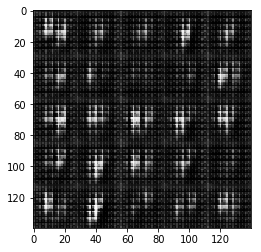

Epoch 1/2... Discriminator Loss: 0.8641... Generator Loss: 1.3737
Epoch 1/2... Discriminator Loss: 0.7646... Generator Loss: 1.7453
Epoch 1/2... Discriminator Loss: 1.0921... Generator Loss: 0.8117
Epoch 1/2... Discriminator Loss: 0.5479... Generator Loss: 2.0483
Epoch 1/2... Discriminator Loss: 0.7620... Generator Loss: 1.2867
Epoch 1/2... Discriminator Loss: 0.9284... Generator Loss: 1.3720
Epoch 1/2... Discriminator Loss: 0.9469... Generator Loss: 1.0351
Epoch 1/2... Discriminator Loss: 1.2673... Generator Loss: 1.8600
Epoch 1/2... Discriminator Loss: 0.7805... Generator Loss: 2.6627
Epoch 1/2... Discriminator Loss: 0.7741... Generator Loss: 1.3588


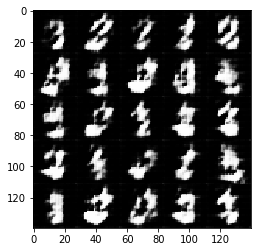

Epoch 1/2... Discriminator Loss: 0.7430... Generator Loss: 2.1876
Epoch 1/2... Discriminator Loss: 0.5746... Generator Loss: 1.9142
Epoch 1/2... Discriminator Loss: 1.2998... Generator Loss: 0.5740
Epoch 1/2... Discriminator Loss: 1.1752... Generator Loss: 0.7489
Epoch 1/2... Discriminator Loss: 1.2628... Generator Loss: 2.2350
Epoch 1/2... Discriminator Loss: 1.0318... Generator Loss: 1.3405
Epoch 1/2... Discriminator Loss: 1.4783... Generator Loss: 2.7058
Epoch 1/2... Discriminator Loss: 0.9998... Generator Loss: 1.1423
Epoch 1/2... Discriminator Loss: 1.4715... Generator Loss: 2.2570
Epoch 1/2... Discriminator Loss: 0.8711... Generator Loss: 1.1314


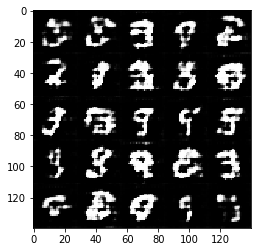

Epoch 1/2... Discriminator Loss: 0.8506... Generator Loss: 1.7337
Epoch 1/2... Discriminator Loss: 0.9108... Generator Loss: 1.0928
Epoch 1/2... Discriminator Loss: 1.5856... Generator Loss: 0.4285
Epoch 1/2... Discriminator Loss: 1.3939... Generator Loss: 0.5508
Epoch 1/2... Discriminator Loss: 1.4196... Generator Loss: 2.0680
Epoch 1/2... Discriminator Loss: 0.8690... Generator Loss: 2.1116
Epoch 1/2... Discriminator Loss: 1.2130... Generator Loss: 0.7712
Epoch 1/2... Discriminator Loss: 1.2548... Generator Loss: 1.4985
Epoch 1/2... Discriminator Loss: 1.0825... Generator Loss: 0.8662
Epoch 1/2... Discriminator Loss: 1.1893... Generator Loss: 0.9056


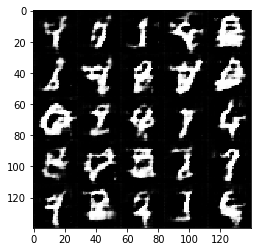

Epoch 1/2... Discriminator Loss: 0.9530... Generator Loss: 1.0727
Epoch 1/2... Discriminator Loss: 1.0251... Generator Loss: 1.0361
Epoch 1/2... Discriminator Loss: 1.0652... Generator Loss: 0.7805
Epoch 1/2... Discriminator Loss: 1.0467... Generator Loss: 0.8308
Epoch 1/2... Discriminator Loss: 1.1787... Generator Loss: 0.8811
Epoch 1/2... Discriminator Loss: 1.3154... Generator Loss: 1.1559
Epoch 1/2... Discriminator Loss: 1.1192... Generator Loss: 1.5203
Epoch 1/2... Discriminator Loss: 1.3286... Generator Loss: 0.6672
Epoch 1/2... Discriminator Loss: 1.3694... Generator Loss: 0.8714
Epoch 1/2... Discriminator Loss: 1.6567... Generator Loss: 0.3353


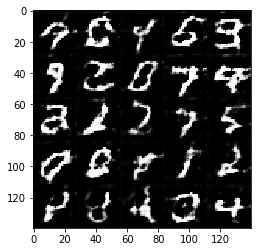

Epoch 1/2... Discriminator Loss: 0.9960... Generator Loss: 0.7976
Epoch 1/2... Discriminator Loss: 1.2227... Generator Loss: 0.8052
Epoch 1/2... Discriminator Loss: 1.1214... Generator Loss: 0.8192
Epoch 1/2... Discriminator Loss: 1.2871... Generator Loss: 1.5078
Epoch 1/2... Discriminator Loss: 1.2587... Generator Loss: 1.4754
Epoch 1/2... Discriminator Loss: 1.8357... Generator Loss: 0.2949
Epoch 1/2... Discriminator Loss: 1.2230... Generator Loss: 0.9833
Epoch 1/2... Discriminator Loss: 1.4859... Generator Loss: 0.5012
Epoch 1/2... Discriminator Loss: 1.1781... Generator Loss: 0.7268
Epoch 1/2... Discriminator Loss: 0.9777... Generator Loss: 1.4211


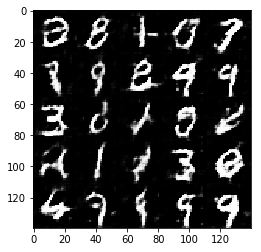

Epoch 1/2... Discriminator Loss: 0.9309... Generator Loss: 1.2320
Epoch 1/2... Discriminator Loss: 0.9597... Generator Loss: 1.9059
Epoch 1/2... Discriminator Loss: 1.4979... Generator Loss: 0.4887
Epoch 1/2... Discriminator Loss: 1.1923... Generator Loss: 1.0810
Epoch 1/2... Discriminator Loss: 1.5190... Generator Loss: 0.4112
Epoch 1/2... Discriminator Loss: 1.1310... Generator Loss: 0.7993
Epoch 1/2... Discriminator Loss: 1.2288... Generator Loss: 1.3391
Epoch 1/2... Discriminator Loss: 1.2742... Generator Loss: 0.6145
Epoch 1/2... Discriminator Loss: 0.8814... Generator Loss: 1.8845
Epoch 1/2... Discriminator Loss: 0.8268... Generator Loss: 1.8160


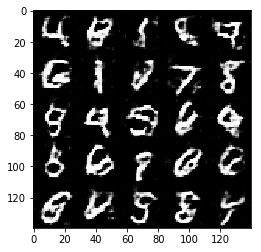

Epoch 1/2... Discriminator Loss: 1.4314... Generator Loss: 1.6497
Epoch 1/2... Discriminator Loss: 1.1752... Generator Loss: 1.0692
Epoch 1/2... Discriminator Loss: 1.1135... Generator Loss: 0.8120
Epoch 1/2... Discriminator Loss: 1.5281... Generator Loss: 0.4174
Epoch 1/2... Discriminator Loss: 1.7892... Generator Loss: 0.3447
Epoch 1/2... Discriminator Loss: 0.9346... Generator Loss: 1.1928
Epoch 1/2... Discriminator Loss: 1.6505... Generator Loss: 0.3819
Epoch 1/2... Discriminator Loss: 1.1565... Generator Loss: 1.0744
Epoch 1/2... Discriminator Loss: 1.1520... Generator Loss: 1.3852
Epoch 1/2... Discriminator Loss: 0.8766... Generator Loss: 1.4016


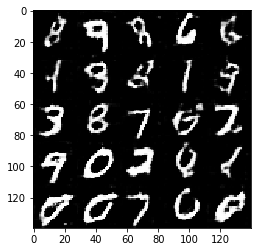

Epoch 1/2... Discriminator Loss: 1.2360... Generator Loss: 0.7987
Epoch 1/2... Discriminator Loss: 1.0718... Generator Loss: 0.8934
Epoch 1/2... Discriminator Loss: 1.6260... Generator Loss: 0.3752
Epoch 1/2... Discriminator Loss: 1.2396... Generator Loss: 0.7867
Epoch 1/2... Discriminator Loss: 1.0970... Generator Loss: 0.7850
Epoch 1/2... Discriminator Loss: 0.7801... Generator Loss: 1.1589
Epoch 1/2... Discriminator Loss: 1.7407... Generator Loss: 0.3271
Epoch 1/2... Discriminator Loss: 1.3469... Generator Loss: 0.8486
Epoch 1/2... Discriminator Loss: 1.5691... Generator Loss: 0.3841
Epoch 1/2... Discriminator Loss: 1.0925... Generator Loss: 2.1813


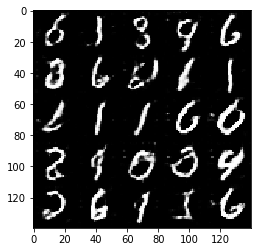

Epoch 1/2... Discriminator Loss: 1.4232... Generator Loss: 0.7362
Epoch 1/2... Discriminator Loss: 0.8161... Generator Loss: 1.2553
Epoch 1/2... Discriminator Loss: 1.9414... Generator Loss: 0.2575
Epoch 2/2... Discriminator Loss: 1.3281... Generator Loss: 0.6304
Epoch 2/2... Discriminator Loss: 1.6337... Generator Loss: 0.3615
Epoch 2/2... Discriminator Loss: 1.5305... Generator Loss: 0.4173
Epoch 2/2... Discriminator Loss: 1.1303... Generator Loss: 1.0252
Epoch 2/2... Discriminator Loss: 1.3436... Generator Loss: 0.6337
Epoch 2/2... Discriminator Loss: 1.1034... Generator Loss: 1.0163
Epoch 2/2... Discriminator Loss: 1.2328... Generator Loss: 1.4518


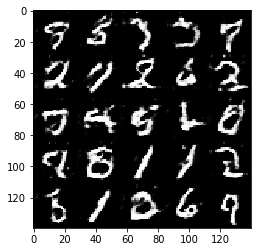

Epoch 2/2... Discriminator Loss: 0.9793... Generator Loss: 1.3946
Epoch 2/2... Discriminator Loss: 0.8558... Generator Loss: 1.2607
Epoch 2/2... Discriminator Loss: 1.5929... Generator Loss: 0.3962
Epoch 2/2... Discriminator Loss: 0.9310... Generator Loss: 1.8948
Epoch 2/2... Discriminator Loss: 1.0826... Generator Loss: 0.9148
Epoch 2/2... Discriminator Loss: 1.2695... Generator Loss: 0.5940
Epoch 2/2... Discriminator Loss: 1.1768... Generator Loss: 0.6303
Epoch 2/2... Discriminator Loss: 1.1559... Generator Loss: 0.6777
Epoch 2/2... Discriminator Loss: 0.6775... Generator Loss: 1.4622
Epoch 2/2... Discriminator Loss: 1.5511... Generator Loss: 1.3412


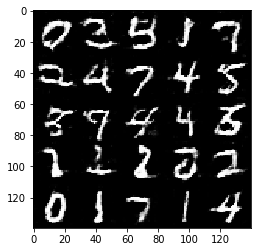

Epoch 2/2... Discriminator Loss: 0.7250... Generator Loss: 1.5767
Epoch 2/2... Discriminator Loss: 1.3442... Generator Loss: 0.7902
Epoch 2/2... Discriminator Loss: 1.8697... Generator Loss: 0.2909
Epoch 2/2... Discriminator Loss: 1.0168... Generator Loss: 0.9033
Epoch 2/2... Discriminator Loss: 1.3756... Generator Loss: 0.4997
Epoch 2/2... Discriminator Loss: 1.4993... Generator Loss: 0.4486
Epoch 2/2... Discriminator Loss: 1.2138... Generator Loss: 0.9900
Epoch 2/2... Discriminator Loss: 1.2217... Generator Loss: 0.5951
Epoch 2/2... Discriminator Loss: 0.9500... Generator Loss: 1.0389
Epoch 2/2... Discriminator Loss: 1.1810... Generator Loss: 0.6229


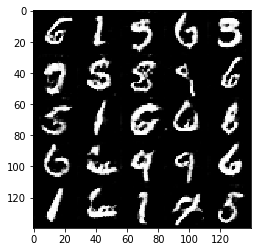

Epoch 2/2... Discriminator Loss: 1.0890... Generator Loss: 0.8044
Epoch 2/2... Discriminator Loss: 1.2347... Generator Loss: 0.8022
Epoch 2/2... Discriminator Loss: 1.0790... Generator Loss: 0.8096
Epoch 2/2... Discriminator Loss: 2.4654... Generator Loss: 0.1787
Epoch 2/2... Discriminator Loss: 1.5096... Generator Loss: 0.4101
Epoch 2/2... Discriminator Loss: 0.9535... Generator Loss: 1.4076
Epoch 2/2... Discriminator Loss: 0.9065... Generator Loss: 1.1571
Epoch 2/2... Discriminator Loss: 1.2864... Generator Loss: 0.8299
Epoch 2/2... Discriminator Loss: 0.9919... Generator Loss: 0.9427
Epoch 2/2... Discriminator Loss: 1.3135... Generator Loss: 0.5414


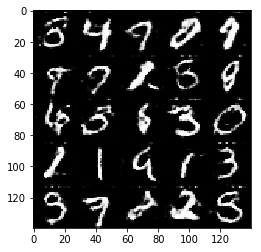

Epoch 2/2... Discriminator Loss: 1.3793... Generator Loss: 0.5004
Epoch 2/2... Discriminator Loss: 0.9854... Generator Loss: 0.7993
Epoch 2/2... Discriminator Loss: 1.0941... Generator Loss: 1.1440
Epoch 2/2... Discriminator Loss: 1.8948... Generator Loss: 0.2842
Epoch 2/2... Discriminator Loss: 0.9887... Generator Loss: 0.8679
Epoch 2/2... Discriminator Loss: 1.0513... Generator Loss: 0.8660
Epoch 2/2... Discriminator Loss: 2.3811... Generator Loss: 0.1655
Epoch 2/2... Discriminator Loss: 1.3350... Generator Loss: 0.5029
Epoch 2/2... Discriminator Loss: 1.4441... Generator Loss: 0.6134
Epoch 2/2... Discriminator Loss: 1.0975... Generator Loss: 1.0679


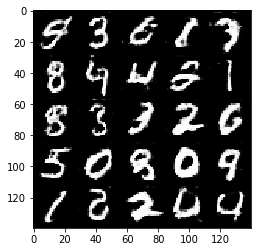

Epoch 2/2... Discriminator Loss: 1.7419... Generator Loss: 0.3278
Epoch 2/2... Discriminator Loss: 0.8629... Generator Loss: 1.9992
Epoch 2/2... Discriminator Loss: 1.5382... Generator Loss: 2.6057
Epoch 2/2... Discriminator Loss: 1.4462... Generator Loss: 0.4555
Epoch 2/2... Discriminator Loss: 1.2311... Generator Loss: 1.2364
Epoch 2/2... Discriminator Loss: 0.8923... Generator Loss: 1.0122
Epoch 2/2... Discriminator Loss: 2.0115... Generator Loss: 0.2358
Epoch 2/2... Discriminator Loss: 2.4264... Generator Loss: 0.2113
Epoch 2/2... Discriminator Loss: 1.2388... Generator Loss: 0.6466
Epoch 2/2... Discriminator Loss: 1.2513... Generator Loss: 0.6472


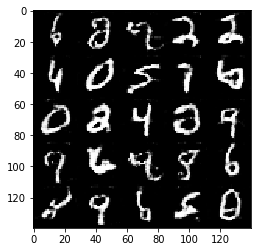

Epoch 2/2... Discriminator Loss: 1.3530... Generator Loss: 0.5527
Epoch 2/2... Discriminator Loss: 1.4556... Generator Loss: 0.4578
Epoch 2/2... Discriminator Loss: 1.0739... Generator Loss: 0.7528
Epoch 2/2... Discriminator Loss: 1.1353... Generator Loss: 1.1865
Epoch 2/2... Discriminator Loss: 1.7340... Generator Loss: 0.3309
Epoch 2/2... Discriminator Loss: 1.1432... Generator Loss: 0.6688
Epoch 2/2... Discriminator Loss: 1.0026... Generator Loss: 0.9060
Epoch 2/2... Discriminator Loss: 2.9498... Generator Loss: 0.1089
Epoch 2/2... Discriminator Loss: 1.0953... Generator Loss: 2.6526
Epoch 2/2... Discriminator Loss: 0.9943... Generator Loss: 0.9212


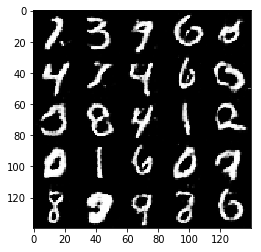

Epoch 2/2... Discriminator Loss: 1.8294... Generator Loss: 0.3146
Epoch 2/2... Discriminator Loss: 2.1266... Generator Loss: 0.2287
Epoch 2/2... Discriminator Loss: 1.4683... Generator Loss: 0.4392
Epoch 2/2... Discriminator Loss: 0.8918... Generator Loss: 0.9392
Epoch 2/2... Discriminator Loss: 0.7988... Generator Loss: 1.1595
Epoch 2/2... Discriminator Loss: 1.1952... Generator Loss: 0.9521
Epoch 2/2... Discriminator Loss: 0.9014... Generator Loss: 0.9906
Epoch 2/2... Discriminator Loss: 1.7395... Generator Loss: 3.2779
Epoch 2/2... Discriminator Loss: 1.1019... Generator Loss: 1.2492
Epoch 2/2... Discriminator Loss: 1.8321... Generator Loss: 0.2902


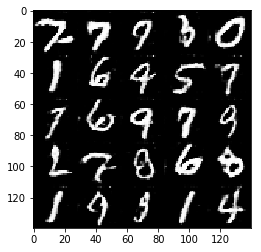

Epoch 2/2... Discriminator Loss: 0.8739... Generator Loss: 0.9911
Epoch 2/2... Discriminator Loss: 1.0863... Generator Loss: 0.7445
Epoch 2/2... Discriminator Loss: 1.2672... Generator Loss: 1.8876
Epoch 2/2... Discriminator Loss: 1.1497... Generator Loss: 0.6657
Epoch 2/2... Discriminator Loss: 1.0410... Generator Loss: 3.3876
Epoch 2/2... Discriminator Loss: 1.5542... Generator Loss: 2.2627
Epoch 2/2... Discriminator Loss: 0.7588... Generator Loss: 1.2240
Epoch 2/2... Discriminator Loss: 0.8599... Generator Loss: 1.0185
Epoch 2/2... Discriminator Loss: 1.4263... Generator Loss: 0.9882
Epoch 2/2... Discriminator Loss: 1.1813... Generator Loss: 3.2017


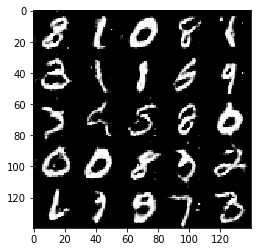

Epoch 2/2... Discriminator Loss: 0.9139... Generator Loss: 1.0520
Epoch 2/2... Discriminator Loss: 0.6078... Generator Loss: 1.7391
Epoch 2/2... Discriminator Loss: 1.9397... Generator Loss: 0.3031
Epoch 2/2... Discriminator Loss: 0.9790... Generator Loss: 0.8716
Epoch 2/2... Discriminator Loss: 0.9955... Generator Loss: 2.0036
Epoch 2/2... Discriminator Loss: 1.4955... Generator Loss: 0.4459
Epoch 2/2... Discriminator Loss: 1.1289... Generator Loss: 0.7735


In [30]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.8332... Generator Loss: 1.1236
Epoch 1/1... Discriminator Loss: 0.7183... Generator Loss: 1.4796
Epoch 1/1... Discriminator Loss: 0.5719... Generator Loss: 1.9384
Epoch 1/1... Discriminator Loss: 0.7032... Generator Loss: 1.6491
Epoch 1/1... Discriminator Loss: 0.7458... Generator Loss: 1.6630
Epoch 1/1... Discriminator Loss: 0.6057... Generator Loss: 1.9677
Epoch 1/1... Discriminator Loss: 0.6657... Generator Loss: 1.6430
Epoch 1/1... Discriminator Loss: 0.5686... Generator Loss: 2.1217
Epoch 1/1... Discriminator Loss: 0.4935... Generator Loss: 2.4701
Epoch 1/1... Discriminator Loss: 0.5100... Generator Loss: 2.5418


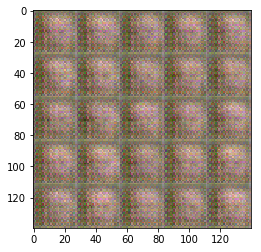

Epoch 1/1... Discriminator Loss: 0.5387... Generator Loss: 2.0200
Epoch 1/1... Discriminator Loss: 1.0214... Generator Loss: 0.8236
Epoch 1/1... Discriminator Loss: 0.8687... Generator Loss: 1.4602
Epoch 1/1... Discriminator Loss: 1.0928... Generator Loss: 2.6676
Epoch 1/1... Discriminator Loss: 0.6750... Generator Loss: 1.8647
Epoch 1/1... Discriminator Loss: 0.7686... Generator Loss: 1.4932
Epoch 1/1... Discriminator Loss: 0.9005... Generator Loss: 1.6912
Epoch 1/1... Discriminator Loss: 0.9208... Generator Loss: 1.2916
Epoch 1/1... Discriminator Loss: 0.7030... Generator Loss: 1.7550
Epoch 1/1... Discriminator Loss: 0.7667... Generator Loss: 1.3966


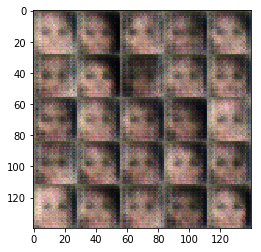

Epoch 1/1... Discriminator Loss: 0.6666... Generator Loss: 1.8630
Epoch 1/1... Discriminator Loss: 0.7045... Generator Loss: 1.4512
Epoch 1/1... Discriminator Loss: 0.6746... Generator Loss: 1.9124
Epoch 1/1... Discriminator Loss: 0.9269... Generator Loss: 1.1858
Epoch 1/1... Discriminator Loss: 0.7971... Generator Loss: 1.8250
Epoch 1/1... Discriminator Loss: 0.7052... Generator Loss: 1.7181
Epoch 1/1... Discriminator Loss: 0.7864... Generator Loss: 1.3406
Epoch 1/1... Discriminator Loss: 0.9598... Generator Loss: 1.4386
Epoch 1/1... Discriminator Loss: 0.8081... Generator Loss: 1.9185
Epoch 1/1... Discriminator Loss: 0.7113... Generator Loss: 1.7184


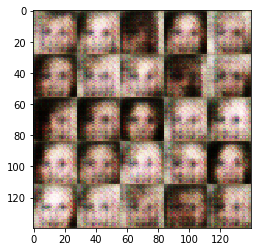

Epoch 1/1... Discriminator Loss: 1.0045... Generator Loss: 1.1680
Epoch 1/1... Discriminator Loss: 1.1938... Generator Loss: 0.8496
Epoch 1/1... Discriminator Loss: 0.7455... Generator Loss: 1.7534
Epoch 1/1... Discriminator Loss: 0.8461... Generator Loss: 1.8878
Epoch 1/1... Discriminator Loss: 0.8765... Generator Loss: 1.1208
Epoch 1/1... Discriminator Loss: 0.8276... Generator Loss: 1.3035
Epoch 1/1... Discriminator Loss: 0.7426... Generator Loss: 1.8618
Epoch 1/1... Discriminator Loss: 0.7795... Generator Loss: 1.9210
Epoch 1/1... Discriminator Loss: 0.9597... Generator Loss: 1.1476
Epoch 1/1... Discriminator Loss: 0.7639... Generator Loss: 1.7368


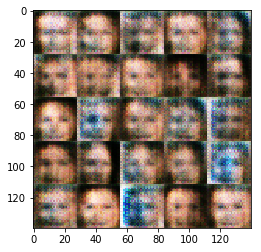

Epoch 1/1... Discriminator Loss: 0.7338... Generator Loss: 1.5996
Epoch 1/1... Discriminator Loss: 0.8801... Generator Loss: 1.5897
Epoch 1/1... Discriminator Loss: 0.8174... Generator Loss: 1.2869
Epoch 1/1... Discriminator Loss: 0.7815... Generator Loss: 1.9014
Epoch 1/1... Discriminator Loss: 1.0651... Generator Loss: 0.8580
Epoch 1/1... Discriminator Loss: 1.0415... Generator Loss: 0.9591
Epoch 1/1... Discriminator Loss: 0.8158... Generator Loss: 1.5216
Epoch 1/1... Discriminator Loss: 1.0206... Generator Loss: 1.1973
Epoch 1/1... Discriminator Loss: 0.9869... Generator Loss: 1.4123
Epoch 1/1... Discriminator Loss: 0.8663... Generator Loss: 1.6544


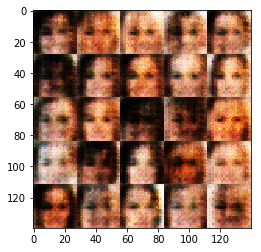

Epoch 1/1... Discriminator Loss: 1.1543... Generator Loss: 1.1795
Epoch 1/1... Discriminator Loss: 0.8914... Generator Loss: 1.6756
Epoch 1/1... Discriminator Loss: 1.0772... Generator Loss: 1.2608
Epoch 1/1... Discriminator Loss: 1.0832... Generator Loss: 0.9383
Epoch 1/1... Discriminator Loss: 0.9567... Generator Loss: 1.3153
Epoch 1/1... Discriminator Loss: 0.9800... Generator Loss: 1.3440
Epoch 1/1... Discriminator Loss: 1.0555... Generator Loss: 0.9630
Epoch 1/1... Discriminator Loss: 1.1760... Generator Loss: 1.1538
Epoch 1/1... Discriminator Loss: 1.1165... Generator Loss: 1.1297
Epoch 1/1... Discriminator Loss: 0.9837... Generator Loss: 1.1845


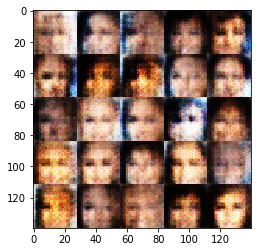

Epoch 1/1... Discriminator Loss: 1.0772... Generator Loss: 1.2504
Epoch 1/1... Discriminator Loss: 1.2246... Generator Loss: 1.2800
Epoch 1/1... Discriminator Loss: 1.3187... Generator Loss: 0.9764
Epoch 1/1... Discriminator Loss: 0.9974... Generator Loss: 1.4345
Epoch 1/1... Discriminator Loss: 1.0246... Generator Loss: 1.1012
Epoch 1/1... Discriminator Loss: 1.1361... Generator Loss: 1.4307
Epoch 1/1... Discriminator Loss: 1.2787... Generator Loss: 1.0313
Epoch 1/1... Discriminator Loss: 1.0501... Generator Loss: 0.9810
Epoch 1/1... Discriminator Loss: 0.9515... Generator Loss: 1.6153
Epoch 1/1... Discriminator Loss: 1.0304... Generator Loss: 1.1547


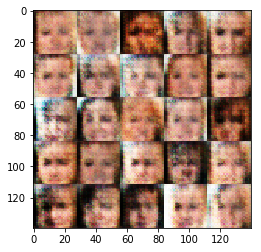

Epoch 1/1... Discriminator Loss: 1.1621... Generator Loss: 0.9368
Epoch 1/1... Discriminator Loss: 1.1506... Generator Loss: 1.0530
Epoch 1/1... Discriminator Loss: 1.1988... Generator Loss: 1.0964
Epoch 1/1... Discriminator Loss: 1.1157... Generator Loss: 1.0102
Epoch 1/1... Discriminator Loss: 1.0155... Generator Loss: 1.0909
Epoch 1/1... Discriminator Loss: 1.1368... Generator Loss: 1.2106
Epoch 1/1... Discriminator Loss: 1.1771... Generator Loss: 1.0509
Epoch 1/1... Discriminator Loss: 1.1554... Generator Loss: 1.0872
Epoch 1/1... Discriminator Loss: 1.0264... Generator Loss: 1.4369
Epoch 1/1... Discriminator Loss: 1.4911... Generator Loss: 0.8228


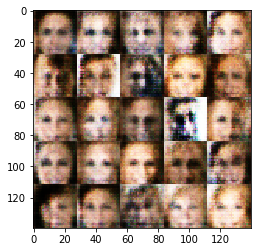

Epoch 1/1... Discriminator Loss: 1.0817... Generator Loss: 1.0920
Epoch 1/1... Discriminator Loss: 1.1106... Generator Loss: 1.3479
Epoch 1/1... Discriminator Loss: 1.0028... Generator Loss: 1.2650
Epoch 1/1... Discriminator Loss: 1.1549... Generator Loss: 1.1066
Epoch 1/1... Discriminator Loss: 1.1498... Generator Loss: 0.9245
Epoch 1/1... Discriminator Loss: 1.0877... Generator Loss: 1.1381
Epoch 1/1... Discriminator Loss: 1.0454... Generator Loss: 1.0510
Epoch 1/1... Discriminator Loss: 0.9895... Generator Loss: 1.3213
Epoch 1/1... Discriminator Loss: 1.1283... Generator Loss: 1.2307
Epoch 1/1... Discriminator Loss: 1.0768... Generator Loss: 1.2357


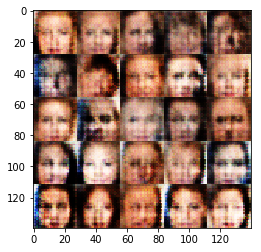

Epoch 1/1... Discriminator Loss: 1.0933... Generator Loss: 1.2156
Epoch 1/1... Discriminator Loss: 1.0574... Generator Loss: 1.2323
Epoch 1/1... Discriminator Loss: 1.1578... Generator Loss: 1.0127
Epoch 1/1... Discriminator Loss: 1.1697... Generator Loss: 1.1394
Epoch 1/1... Discriminator Loss: 1.0536... Generator Loss: 1.0826
Epoch 1/1... Discriminator Loss: 1.1146... Generator Loss: 1.0144
Epoch 1/1... Discriminator Loss: 0.9400... Generator Loss: 1.2779
Epoch 1/1... Discriminator Loss: 1.1557... Generator Loss: 1.1593
Epoch 1/1... Discriminator Loss: 1.2083... Generator Loss: 0.9707
Epoch 1/1... Discriminator Loss: 1.1095... Generator Loss: 1.1243


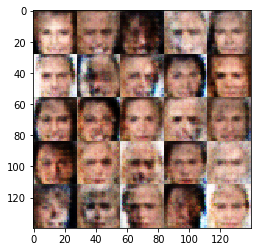

Epoch 1/1... Discriminator Loss: 1.0488... Generator Loss: 1.3644
Epoch 1/1... Discriminator Loss: 1.0135... Generator Loss: 1.0396
Epoch 1/1... Discriminator Loss: 1.1100... Generator Loss: 1.0520
Epoch 1/1... Discriminator Loss: 0.9861... Generator Loss: 1.2232
Epoch 1/1... Discriminator Loss: 1.0523... Generator Loss: 0.9901
Epoch 1/1... Discriminator Loss: 1.1605... Generator Loss: 0.8411
Epoch 1/1... Discriminator Loss: 1.1356... Generator Loss: 1.3456
Epoch 1/1... Discriminator Loss: 1.1521... Generator Loss: 0.9806
Epoch 1/1... Discriminator Loss: 1.1220... Generator Loss: 1.0981
Epoch 1/1... Discriminator Loss: 1.2529... Generator Loss: 0.7778


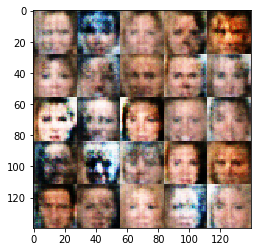

Epoch 1/1... Discriminator Loss: 1.0013... Generator Loss: 1.5007
Epoch 1/1... Discriminator Loss: 1.1274... Generator Loss: 1.3906
Epoch 1/1... Discriminator Loss: 1.2275... Generator Loss: 0.9598
Epoch 1/1... Discriminator Loss: 1.1449... Generator Loss: 1.1850
Epoch 1/1... Discriminator Loss: 1.1374... Generator Loss: 0.9252
Epoch 1/1... Discriminator Loss: 1.2329... Generator Loss: 0.8970
Epoch 1/1... Discriminator Loss: 1.1878... Generator Loss: 0.9799
Epoch 1/1... Discriminator Loss: 1.1385... Generator Loss: 0.7996
Epoch 1/1... Discriminator Loss: 1.1516... Generator Loss: 0.7982
Epoch 1/1... Discriminator Loss: 1.1666... Generator Loss: 0.8963


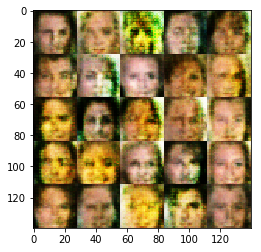

Epoch 1/1... Discriminator Loss: 0.9489... Generator Loss: 1.0903
Epoch 1/1... Discriminator Loss: 1.0535... Generator Loss: 1.1339
Epoch 1/1... Discriminator Loss: 0.9278... Generator Loss: 1.4313
Epoch 1/1... Discriminator Loss: 1.0893... Generator Loss: 1.1127
Epoch 1/1... Discriminator Loss: 1.1805... Generator Loss: 1.3828
Epoch 1/1... Discriminator Loss: 1.0425... Generator Loss: 1.0421
Epoch 1/1... Discriminator Loss: 1.0173... Generator Loss: 1.0712
Epoch 1/1... Discriminator Loss: 1.0182... Generator Loss: 1.1307
Epoch 1/1... Discriminator Loss: 1.1672... Generator Loss: 0.8037
Epoch 1/1... Discriminator Loss: 1.1634... Generator Loss: 0.7014


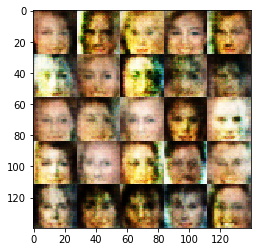

Epoch 1/1... Discriminator Loss: 1.0533... Generator Loss: 1.2971
Epoch 1/1... Discriminator Loss: 1.2519... Generator Loss: 0.8545
Epoch 1/1... Discriminator Loss: 1.0542... Generator Loss: 1.4297
Epoch 1/1... Discriminator Loss: 1.0761... Generator Loss: 0.8894
Epoch 1/1... Discriminator Loss: 1.0210... Generator Loss: 1.1605
Epoch 1/1... Discriminator Loss: 1.1277... Generator Loss: 0.8876
Epoch 1/1... Discriminator Loss: 1.0323... Generator Loss: 1.2538
Epoch 1/1... Discriminator Loss: 0.9286... Generator Loss: 1.4003
Epoch 1/1... Discriminator Loss: 1.0664... Generator Loss: 1.0606
Epoch 1/1... Discriminator Loss: 1.2267... Generator Loss: 1.0161


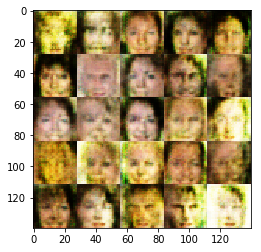

Epoch 1/1... Discriminator Loss: 0.8149... Generator Loss: 1.4132
Epoch 1/1... Discriminator Loss: 0.9282... Generator Loss: 1.2893
Epoch 1/1... Discriminator Loss: 0.9695... Generator Loss: 1.3138
Epoch 1/1... Discriminator Loss: 0.9962... Generator Loss: 1.0483
Epoch 1/1... Discriminator Loss: 1.0856... Generator Loss: 1.1654
Epoch 1/1... Discriminator Loss: 1.0329... Generator Loss: 1.4352
Epoch 1/1... Discriminator Loss: 1.1404... Generator Loss: 0.9086
Epoch 1/1... Discriminator Loss: 1.0078... Generator Loss: 1.2080
Epoch 1/1... Discriminator Loss: 0.9907... Generator Loss: 1.0606
Epoch 1/1... Discriminator Loss: 1.2160... Generator Loss: 0.7742


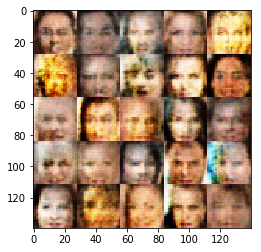

Epoch 1/1... Discriminator Loss: 0.9382... Generator Loss: 1.8454
Epoch 1/1... Discriminator Loss: 1.1438... Generator Loss: 1.1165
Epoch 1/1... Discriminator Loss: 1.1025... Generator Loss: 1.2784
Epoch 1/1... Discriminator Loss: 1.0790... Generator Loss: 0.9753
Epoch 1/1... Discriminator Loss: 1.0047... Generator Loss: 1.3226
Epoch 1/1... Discriminator Loss: 0.9376... Generator Loss: 1.1422
Epoch 1/1... Discriminator Loss: 0.9980... Generator Loss: 1.4585
Epoch 1/1... Discriminator Loss: 1.1347... Generator Loss: 0.9810


In [31]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.